# Deep Learning

## Assignment 1

In [27]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Download the training and data files for this assignment.

In [4]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./data\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./data\notMNIST_small.tar.gz


Unzip the files.

In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./data\notMNIST_large. This may take a while. Please wait.
['./data\\notMNIST_large\\A', './data\\notMNIST_large\\B', './data\\notMNIST_large\\C', './data\\notMNIST_large\\D', './data\\notMNIST_large\\E', './data\\notMNIST_large\\F', './data\\notMNIST_large\\G', './data\\notMNIST_large\\H', './data\\notMNIST_large\\I', './data\\notMNIST_large\\J']
Extracting data for ./data\notMNIST_small. This may take a while. Please wait.
['./data\\notMNIST_small\\A', './data\\notMNIST_small\\B', './data\\notMNIST_small\\C', './data\\notMNIST_small\\D', './data\\notMNIST_small\\E', './data\\notMNIST_small\\F', './data\\notMNIST_small\\G', './data\\notMNIST_small\\H', './data\\notMNIST_small\\I', './data\\notMNIST_small\\J']


### Problem 1
Load the data in a more manageable format. We'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.
We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
A few images might not be readable, we'll just skip them.

In [12]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./data\notMNIST_large\A.pickle already present - Skipping pickling.
./data\notMNIST_large\B.pickle already present - Skipping pickling.
./data\notMNIST_large\C.pickle already present - Skipping pickling.
./data\notMNIST_large\D.pickle already present - Skipping pickling.
./data\notMNIST_large\E.pickle already present - Skipping pickling.
./data\notMNIST_large\F.pickle already present - Skipping pickling.
./data\notMNIST_large\G.pickle already present - Skipping pickling.
./data\notMNIST_large\H.pickle already present - Skipping pickling.
./data\notMNIST_large\I.pickle already present - Skipping pickling.
./data\notMNIST_large\J.pickle already present - Skipping pickling.
./data\notMNIST_small\A.pickle already present - Skipping pickling.
./data\notMNIST_small\B.pickle already present - Skipping pickling.
./data\notMNIST_small\C.pickle already present - Skipping pickling.
./data\notMNIST_small\D.pickle already present - Skipping pickling.
./data\notMNIST_small\E.pickle already present -

### Problem 2

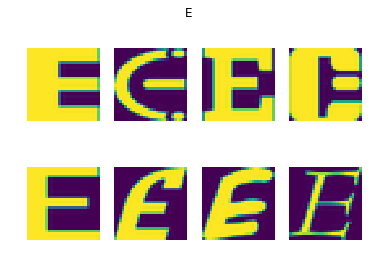

In [36]:
def disp_sample_pickles(data_folders):
    folder = random.sample(data_folders, 1)
    pickle_filename = ''.join(folder) + '.pickle'
    try:
        with open(pickle_filename, 'rb') as f:
            dataset = pickle.load(f)
    except Exception as e:
        print('Unable to read data from', pickle_filename, ':', e)
        return
    plt.suptitle(''.join(folder)[-1])
    for i, img in enumerate(random.sample(list(dataset), 8)):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)
        
disp_sample_pickles(train_folders)